In [1]:
import hashlib
import numpy as np
import math
import collections
from zlib import crc32
import random
import operator
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
from sympy import Symbol, solve, log
from scipy.optimize import fsolve
import scipy
import hashlib
import array
import matplotlib.cm as cm
import operator
from collections import defaultdict
import pandas as pd
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__)) 
# use matplotlib: 3.1.0
from spacesaving import SpaceSaving, DoubleSpaceSaving
from githubCountMin import CountMinSketch
from CSSS import CSSS_CountSketch as CountSketch
import heapq
from unbiasedSpaceSaving import UnbiasedDSS
from Panakos import Panakos
from HeavyKeeper import HeavyKeeper
import json


matplotlib: 3.1.0


In [2]:
with open('./data/social_friends_weibo.json', 'r') as file:
    social = json.load(file)
print(len(social))

1501240


In [12]:
    def frequency_estimation(stream_type, shuffled, arr, skew=1.0, s = 10**4, univ = 2**23, r = 0.5):
        random.seed(1)
        udss_avg = {}
        dss_avg = {}
        iss_avg = {}
        cm_avg = {}
        cs_avg = {}
        panakos_avg = {}
        heavykeeper_avg = {}
        
        
        total_spaces = {}
        Turnstile_model_maker = ['^:','^-.']
        markers = ['kv-','kx--','kp:']
        runs = 1
        universe = univ
        size = s
        a = skew
        epsilons = [2**(-8), 2**(-9), 2**(-10), 2**(-11)]
        rates = [r]
        insertions = []
        deletions = []
        
        if arr:
            universe = max(arr)
            num_deletions = sum([i<0 for i in arr])
            rates[0] = num_deletions / (len(arr) - num_deletions)
            
        if not arr:
            # making sure size = |F| = I - D = insert_size(1-r)
            # stream length = I + D = insert_size(1+r)
            insert_size = size
            print('insert_size: ', size)

            if stream_type == 'zipf':
                with open('./data/zipf1_inserts.json', 'r') as file:
                    insertions= json.load(file)
                insretions = insertions[:insert_size]
            else:
                print('accessing CAIDA dataset')
                df = pd.read_csv('./data/20151217_125911_dirA.csv',sep='\t') 
                insertions = df[df.columns[3]].iloc[:insert_size].tolist()
            deletions = random.sample(list(insertions), int(r*len(insertions)))
                
        
        for i in range(len(rates)):
            rate = rates[i]
            
            dss_avg_errors = []
            udss_avg_errors = []
            iss_avg_errors = []
            cm_avg_errors = []
            cs_avg_errors = []
            
            panakos_avg_errors = []
            heavykeeper_avg_errors = []

            total_space = []

            for eps in epsilons:
                sum_iss_avg_error = 0
                sum_dss_avg_error = 0
                sum_cm_avg_error = 0
                sum_cs_avg_error = 0
                sum_panakos_avg_error = 0
                sum_heavykeepr_avg_error = 0
                

                CM = CountMinSketch(int(1/eps), 16) #cols, rows
                CS = CountSketch(16, int(1/eps))
                space_used = CM.space()
                total_space.append(space_used * 4 / (1024))
                ISS = SpaceSaving(space_used//3) #item, insertcount, deletecount
                DSS = DoubleSpaceSaving(eps, space_used//2) #item and count, it will split once again b/t insert/delete
                UDSS = UnbiasedDSS(eps, space_used//2)
                panakos = Panakos(space_used) # inside panakos, it will do a division of 3 for spacesaving
                
                # let's track 200 items in the min heap
                # heap: (item, count)
                heavykeeper = HeavyKeeper((space_used-400)//1.5, 200) # fingerprint + counter
                
                true_result = {}
                    
                if arr:
                    for i in arr:
                        if i > 0:
                            ISS.update(str(i), 1)
                            DSS.update(str(i), 1, True)
                            UDSS.update(str(i), 1, True)
                            CM.add(str(i), 1)
                            CS.add(str(i), 1)
                            panakos.update(str(i), 1)
                            heavykeeper.update(str(i), 1)
                            true_result[str(i)] = true_result.get(str(i), 0) + 1
                        else:
                            i = abs(i) # assume negative number is deletion
                            assert str(i) in true_result
                            ISS.update(str(i), -1)
                            DSS.update(str(i), 1, False)
                            UDSS.update(str(i), 1, False)
                            CM.add(str(i), -1)
                            CS.add(str(i), -1)
                            panakos.update(str(i), -1)
                            heavykeeper.update(str(i), -1)
                            true_result[str(i)] = true_result.get(str(i), 0) - 1
                else:
                    print('processing stream')
                    for i in insertions:
                        ISS.update(str(i), 1)
                        DSS.update(str(i), 1, True)
                        UDSS.update(str(i), 1, True)
                        CM.add(str(i), 1)
                        CS.add(str(i), 1)
                        panakos.update(str(i), 1)
                        heavykeeper.update(str(i), 1)
                        true_result[str(i)] = true_result.get(str(i), 0) + 1

                    for i in deletions:
                        assert str(i) in true_result
                        ISS.update(str(i), -1)
                        DSS.update(str(i), 1, False)
                        UDSS.update(str(i), 1, False)
                        CM.add(str(i), -1)
                        CS.add(str(i), -1)
                        panakos.update(str(i), -1)
                        heavykeeper.update(str(i), -1)
                        true_result[str(i)] = true_result.get(str(i), 0) - 1

                iss_avg_error = 0
                dss_avg_error = 0
                udss_avg_error = 0
                cm_avg_error = 0
                cs_avg_error = 0
                panakos_avg_error = 0
                heavykeeper_avg_error = 0
                
                u = 0
                assert len(true_result.keys()) != 0, print(true_result)
                for item in true_result.keys():
                    if true_result[item] == 0:
                        continue
                    u += 1
                    dss_estimate = DSS.query(item)
                    dss_error = 1.0 * abs(true_result.get(item,0) - dss_estimate) / true_result.get(item,0)
                        
                    udss_estimate = UDSS.query(item)
                    udss_error = 1.0 * abs(true_result.get(item,0) - udss_estimate) / true_result.get(item,0)
        
                    iss_estimate = ISS.query(item)
                    iss_error = 1.0 *  abs(true_result.get(item,0) - iss_estimate) / true_result.get(item,0)

                    cm_estimate = CM.query(item)
                    cm_error = 1.0 *  abs(true_result.get(item,0) - cm_estimate) / true_result.get(item,0)
                        
                    cs_estimate = CS.query(item)
                    cs_error = 1.0 *  abs(true_result.get(item,0) - cs_estimate) / true_result.get(item,0)
                    
                    panakos_estimate = panakos.query(item)
                    panakos_error = 1.0 *  abs(true_result.get(item,0) - panakos_estimate) / true_result.get(item,0)
                    
                    heavykeeper_estimate = heavykeeper.query(item)
                    heavykeeper_error = 1.0 *  abs(true_result.get(item,0) - heavykeeper_estimate) / true_result.get(item,0)

                    iss_avg_error += iss_error
                    dss_avg_error += dss_error
                    udss_avg_error += udss_error
                    cm_avg_error += cm_error
                    cs_avg_error += cs_error
                    panakos_avg_error += panakos_error
                    heavykeeper_avg_error += heavykeeper_error
                
                dss_avg_error = 1.0 * dss_avg_error / u
                udss_avg_error = 1.0 * udss_avg_error / u
                iss_avg_error = 1.0 * iss_avg_error / u
                cm_avg_error = 1.0 * cm_avg_error / u
                cs_avg_error = 1.0 * cs_avg_error / u
                panakos_avg_error = 1.0 * panakos_avg_error / u
                heavykeeper_avg_error = 1.0 * heavykeeper_avg_error / u

                iss_avg_errors.append(iss_avg_error)
                dss_avg_errors.append(dss_avg_error)
                udss_avg_errors.append(udss_avg_error)
                cm_avg_errors.append(cm_avg_error)
                cs_avg_errors.append(cs_avg_error)
                panakos_avg_errors.append(panakos_avg_error)
                heavykeeper_avg_errors.append(heavykeeper_avg_error)

            iss_avg[rate] = iss_avg_errors
            dss_avg[rate] = dss_avg_errors
            udss_avg[rate] = udss_avg_errors
            cm_avg[rate] = cm_avg_errors
            cs_avg[rate] = cs_avg_errors
            panakos_avg[rate] = panakos_avg_errors
            heavykeeper_avg[rate] = heavykeeper_avg_errors
            total_spaces[rate] = total_space


        plt.figure()
        plt.xlabel('Memory (KB)')
        plt.ylabel('Average Relative Error')
        
        plt.rc('xtick')
        plt.rc('ytick')
        
#         plt.yscale('log', basey=10)
        for i in range(len(rates)):
            plt.plot(total_spaces[rates[i]], iss_avg[rates[i]], markers[0], label='ISpaceSaving\u00B1')
            plt.plot(total_spaces[rates[i]], dss_avg[rates[i]], markers[1], label='DSpaceSaving\u00B1')
            plt.plot(total_spaces[rates[i]], udss_avg[rates[i]], markers[2], label='UDSpaceSaving\u00B1')
            plt.plot(total_spaces[rates[i]], cm_avg[rates[i]], Turnstile_model_maker[0] ,label='Count-Min')
            plt.plot(total_spaces[rates[i]], cs_avg[rates[i]], Turnstile_model_maker[1],label='Count Sketch')
            plt.plot(total_spaces[rates[i]], panakos_avg[rates[i]], marker='*', linestyle='--', color='brown', label='Panakos')
            plt.plot(total_spaces[rates[i]], heavykeeper_avg[rates[i]], marker='D', linestyle='-.', color='grey', label='HeavyKeeper')
        print("spaces: ", total_spaces)
        print("iss: ", iss_avg)
        print("dss: ", dss_avg)
        print("udss: ", udss_avg)
        print("cm: ", cm_avg)
        print("cs: ", cs_avg)
        print("panakos: ", panakos_avg)
        print("heavykeeper: ", heavykeeper_avg)
        plt.legend()
        

spaces:  {0.042883372038660404: [16.0, 32.0, 64.0, 128.0]}
iss:  {0.042883372038660404: [5.988522527184685, 1.9666945874060993, 0.8020312666621456, 0.0]}
dss:  {0.042883372038660404: [6.819677647628385, 2.0227571058111464, 1.072486931230401, 0.0]}
udss:  {0.042883372038660404: [2.03484419224311, 1.8535390512108925, 1.055533093117716, 0.0]}
cm:  {0.042883372038660404: [473.04458168024223, 101.69146636672112, 9.431935511492759, 1.2843361353729728]}
cs:  {0.042883372038660404: [132.01490465783547, 89.73435652153552, 34.205617198114275, 6.445234532556754]}
panakos:  {0.042883372038660404: [3.785348431852227, 2.40371361207324, 0.13270474951677377, 0.045395148548499235]}
heavykeeper:  {0.042883372038660404: [0.8988064259717734, 0.8277818013216751, 0.7236594620801731, 0.4178580896149863]}


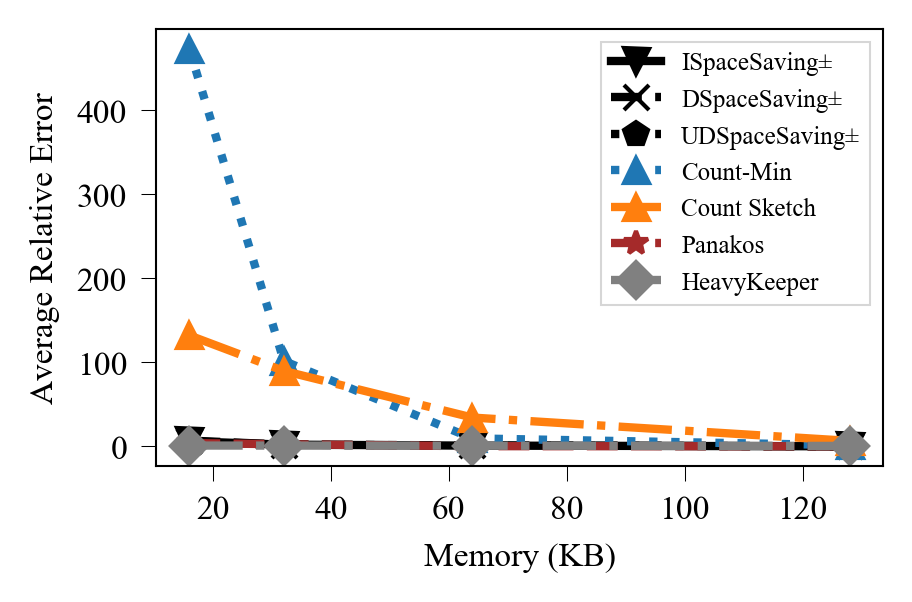

In [5]:
frequency_estimation('Social Network', True, social)

insert_size:  1000000
processing stream
processing stream
processing stream
processing stream
spaces:  {0.25: [16.0, 32.0, 64.0, 128.0]}
iss:  {0.25: [2.0986854612903927, 2.0606482568908278, 2.039863508408711, 2.0252310969087333]}
dss:  {0.25: [2.1239681782535547, 2.063620112064441, 2.0430366503961888, 2.033205149298001]}
udss:  {0.25: [2.1648065061409283, 2.0847993074795026, 2.0853279618487095, 2.0434190404005967]}
cm:  {0.25: [1287.6712059607, 585.1081603942778, 260.7787657559098, 114.68131696081409]}
cs:  {0.25: [91.66334227237284, 32.16154942024157, 16.09061445554322, 9.47571200912257]}
panakos:  {0.25: [1.9978097722632124, 4.074138701943895, 6.630671623986549, 2.4877311292342146]}
heavykeeper:  {0.25: [1.0765292025034991, 1.0411119823007082, 1.0038242413851677, 0.9986754222066099]}


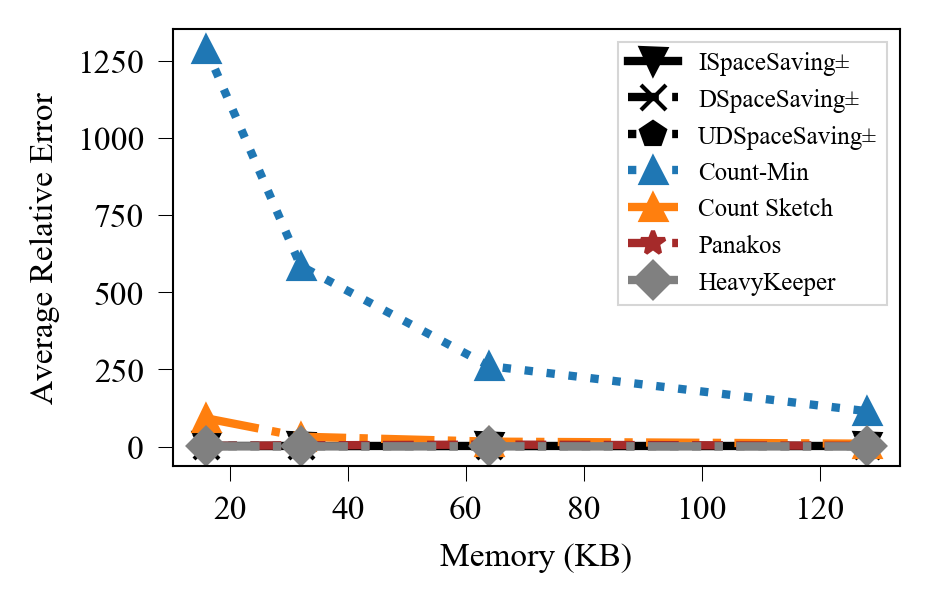

In [5]:
frequency_estimation('zipf', True, [], 1.0, 10**6, 2**21, 0.25)

insert_size:  1000000
accessing CAIDA dataset
processing stream
processing stream
processing stream
processing stream
spaces:  {0.5: [16.0, 32.0, 64.0, 128.0]}
iss:  {0.5: [2.857622771974398, 2.548752843167775, 1.9717522216127141, 0.9173243647086214]}
dss:  {0.5: [2.9316768089208263, 2.6674658730296867, 2.2255920856553, 1.3503492740625698]}
udss:  {0.5: [2.5894217286668857, 2.583437270102188, 2.1710069043018465, 1.3722190557528073]}
cm:  {0.5: [249.37849373526123, 92.06525730103826, 29.595819091136526, 7.458135298644463]}
cs:  {0.5: [54.20761305183758, 25.24805675395111, 12.402179177783566, 5.913373836037911]}
panakos:  {0.5: [1.9724295155594602, 1.3255535114533126, 0.6753127410192048, 0.1329340851892203]}
heavykeeper:  {0.5: [0.9984652539808717, 1.1481395145880968, 0.8651542432368736, 0.7102775963488475]}


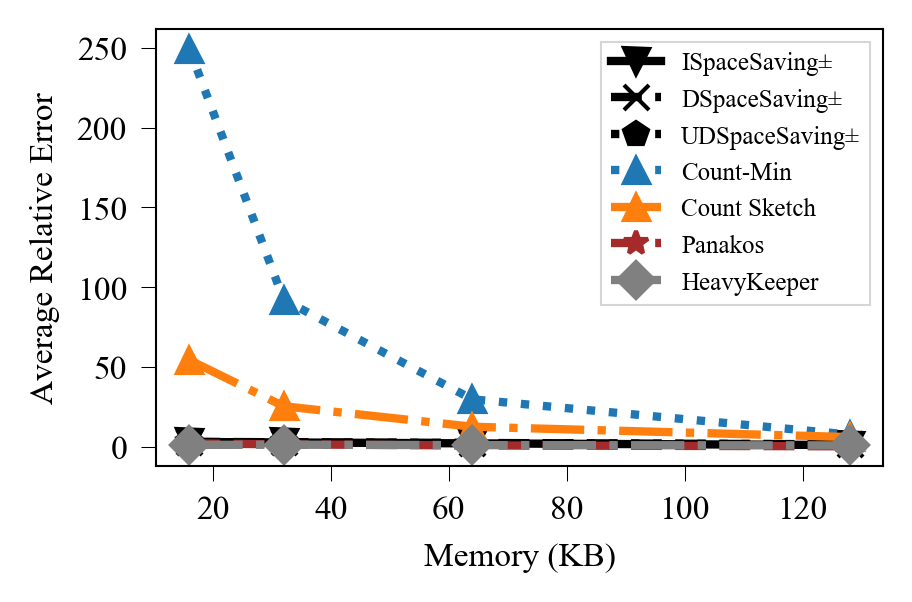

In [13]:
frequency_estimation('CAIDA', True, [], 1.0, 10**6)

In [8]:
def precision(trueHH, estimatedHH):
    TP, FP = 0.0, 0.0
    for item in estimatedHH:
        if item in trueHH:
            TP += 1
        else:
            FP += 1
    return 1.0*TP/(TP+FP)

def recall(trueHH, estimatedHH):
    TP, FN = 0.0, 0.0
    for item in trueHH:
        if item in estimatedHH:
            TP += 1
        else:
            FN += 1
    return 1.0*TP/(TP+FN)
def FScore(trueHH, estimatedHH):
    r = recall(trueHH, estimatedHH)
    p = precision(trueHH, estimatedHH)
    if (r+p) == 0:
        return 0
    return 2.0*r*p/(r+p)

def TopK(streamType = "zipf", k=10, streamLength = 10**5, delete_insert_ratio = 0.5, dataset = []):
    random.seed(0)
    Turnstile_model_maker = ['^:','^-.']
    markers = ['kv-','kx--','kp:']
    
    CM_errors = []
    CS_errors = []
    ISS_errors = []
    DSS_errors = []
    UDSS_errors = []
    panakos_errors = []
    heavykeeper_errors = []
    
    spaces = []
    
    a = 1.0
    insert_size = streamLength
    print('insert_size: ', insert_size)
    universe = 2**21
    if dataset:
        universe = max(dataset)
    epsilons = [2**(-8), 2**(-9), 2**(-10), 2**(-11)]
    rates = [delete_insert_ratio]
    r = delete_insert_ratio
    insertoins = []
    deletions = []
        

    for index, rate in enumerate(rates):
        for eps in epsilons:
            if not dataset:
                if streamType == "zipf":
                    with open('./data/zipf1_inserts.json', 'r') as file:
                        insertions= json.load(file)
                    insretions = insertions[:insert_size]
                else:
                    df = pd.read_csv('./data/20151217_125911_dirA.csv',sep='\t') 
                    insertions = df[df.columns[3]].iloc[:insert_size].tolist()
                deletions = random.sample(list(insertions), int(r*len(insertions)))
                
            CM = CountMinSketch(int(1/eps), 16) #cols, rows
            CS = CountSketch(16, int(1/eps))
            space_used = CM.space()
            spaces.append(space_used)
            ISS = SpaceSaving(space_used//3) #item, insertcount, deletecount
            DSS = DoubleSpaceSaving(eps, space_used//2) #item and count, it will split once again b/t insert/delete
            UDSS = UnbiasedDSS(eps, space_used//2)
            panakos = Panakos(space_used)
            heavykeeper = HeavyKeeper((space_used-400)//1.5, 200)
            
            
            true_result = {}
            if dataset:
                for i in dataset:
                    if i > 0:
                        ISS.update(str(i), 1)
                        DSS.update(str(i), 1, True)
                        UDSS.update(str(i), 1, True)
                        CM.add(str(i), 1)
                        CS.add(str(i), 1)
                        panakos.update(str(i), 1)
                        heavykeeper.update(str(i), 1)
                        true_result[str(i)] = true_result.get(str(i), 0) + 1
                    else:
                        i = abs(i)
                        assert str(i) in true_result
                        ISS.update(str(i), -1)
                        DSS.update(str(i), 1, False)
                        UDSS.update(str(i), 1, False)
                        CM.add(str(i), -1)
                        CS.add(str(i), -1)
                        panakos.update(str(i), -1)
                        heavykeeper.update(str(i), -1)
                        true_result[str(i)] = true_result.get(str(i), 0) - 1
            else:
                for i in insertions:
                    ISS.update(str(i), 1)
                    DSS.update(str(i), 1, True)
                    UDSS.update(str(i), 1, True)
                    CM.add(str(i), 1)
                    CS.add(str(i), 1)
                    panakos.update(str(i), 1)
                    heavykeeper.update(str(i), 1)
                    true_result[str(i)] = true_result.get(str(i), 0) + 1

                for i in deletions:
                    assert str(i) in true_result
                    ISS.update(str(i), -1)
                    DSS.update(str(i), 1, False)
                    UDSS.update(str(i), 1, False)
                    CM.add(str(i), -1)
                    CS.add(str(i), -1)
                    panakos.update(str(i), -1)
                    heavykeeper.update(str(i), -1)
                    true_result[str(i)] -= 1
                    assert true_result[str(i)] >= 0
            
            CM_error, CS_error, CM_estimate, CS_estimate  = 0, 0, 0, 0
            ISS_error, DSS_error, UDSS_error, ISS_estimate, DSS_estimate, UDSS_estimate  = 0, 0, 0, 0, 0, 0
            panakos_error, panakos_error, heavykeeper_estimate, heavykeeper_estimate  = 0, 0, 0, 0
            
            CM_dic = {}
            CS_dic = {}
            ISS_dic = {}
            DSS_dic = {}
            UDSS_dic = {}
            panakos_dic = {}
            heavykeeper_dic = {}
            
            trueTopK = heapq.nlargest(k, true_result, key=true_result.get)
            
            for item in true_result.keys():
                CM_dic[item] = CM.query(item)
                CS_dic[item] = CS.query(item)
                ISS_dic[item] = ISS.query(item)
                DSS_dic[item] = DSS.query(item)
                UDSS_dic[item] = UDSS.query(item)
                panakos_dic[item] = panakos.query(item)
                heavykeeper_dic[item] = heavykeeper.query(item)
            
            
                
            CM_error = FScore(trueTopK, heapq.nlargest(k, CM_dic, key=CM_dic.get))
            CS_error = FScore(trueTopK, heapq.nlargest(k, CS_dic, key=CS_dic.get))
            DSS_error = FScore(trueTopK, heapq.nlargest(k, DSS_dic, key=DSS_dic.get))
            UDSS_error = FScore(trueTopK, heapq.nlargest(k, UDSS_dic, key=DSS_dic.get))
            ISS_error = FScore(trueTopK, heapq.nlargest(k, ISS_dic, key=ISS_dic.get))
            panakos_error = FScore(trueTopK, heapq.nlargest(k, panakos_dic, key=panakos_dic.get))
            heavykeeper_error = FScore(trueTopK, heapq.nlargest(k, heavykeeper_dic, key=heavykeeper_dic.get))
            
            CM_errors.append(CM_error)
            CS_errors.append(CS_error)
            DSS_errors.append(DSS_error)
            UDSS_errors.append(UDSS_error)
            ISS_errors.append(ISS_error)
            panakos_errors.append(UDSS_error)
            heavykeeper_errors.append(ISS_error)

    plt.xlabel('Memory (KB)')
    plt.ylabel('F1 Score')
    
    for i in range(len(spaces)):
        spaces[i] = int(spaces[i]*4/1024)

    plt.ylim(0,1.05)
    plt.plot(spaces, ISS_errors, markers[0], label='ISpaceSaving\u00B1')
    plt.plot(spaces, DSS_errors, markers[1], label='DSpaceSaving\u00B1')
    plt.plot(spaces, UDSS_errors, markers[2], label='UDSpaceSaving\u00B1')
    
    plt.plot(spaces, CM_errors, Turnstile_model_maker[0], label='Count-Min')
    plt.plot(spaces, CS_errors, Turnstile_model_maker[1], label='Count Sketch')
    
    plt.plot(spaces, panakos_errors, marker='*', linestyle='--', color='brown', label='Panakos')
    plt.plot(spaces, heavykeeper_errors,  marker='D', linestyle='-.', color='grey', label='HeavyKeeper')
    
    print(spaces)
    print("CM: ", CM_errors)
    print("CS: ", CS_errors)
    print("DSS: ", DSS_errors)
    print("UDSS: ", UDSS_errors)
    print("ISS: ", ISS_errors)
    print("Panakos: ", panakos_errors)
    print("HeavyKeeper: ", heavykeeper_errors)

    plt.legend()

insert_size:  1000000
[16, 32, 64, 128]
CM:  [0.9, 0.93, 0.97, 0.99]
CS:  [0.66, 0.93, 0.98, 0.98]
DSS:  [0.82, 0.99, 1.0, 1.0]
UDSS:  [0.82, 0.99, 1.0, 1.0]
ISS:  [0.96, 1.0, 1.0, 1.0]
Panakos:  [0.82, 0.99, 1.0, 1.0]
HeavyKeeper:  [0.96, 1.0, 1.0, 1.0]


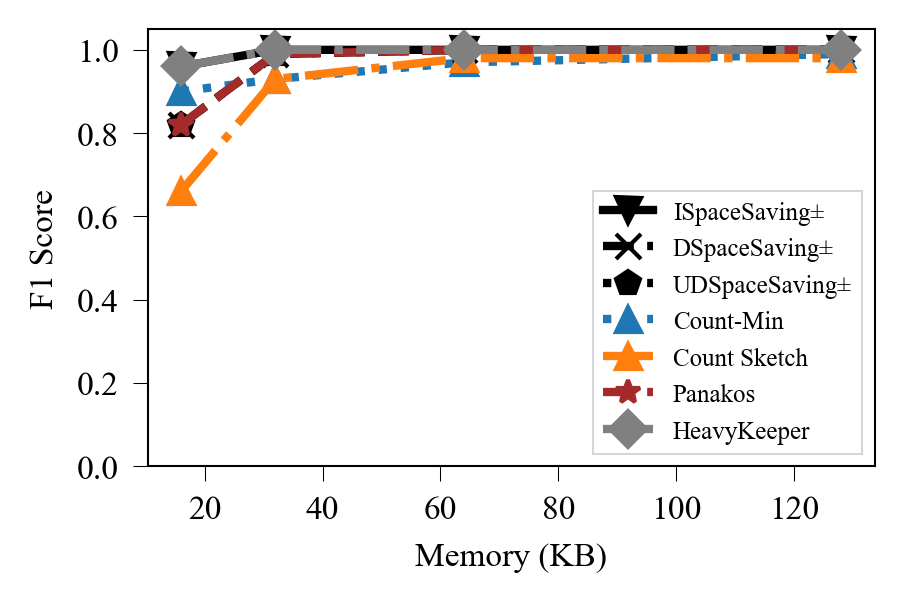

In [8]:
TopK('zipf', 100, 10**6, 0.25)

insert_size:  1501240
[16, 32, 64, 128]
CM:  [0.26, 0.44, 0.96, 0.99]
CS:  [0.37, 0.45, 0.63, 0.96]
DSS:  [0.98, 1.0, 1.0, 1.0]
UDSS:  [0.98, 1.0, 1.0, 1.0]
ISS:  [0.98, 1.0, 1.0, 1.0]
Panakos:  [0.98, 1.0, 1.0, 1.0]
HeavyKeeper:  [0.98, 1.0, 1.0, 1.0]


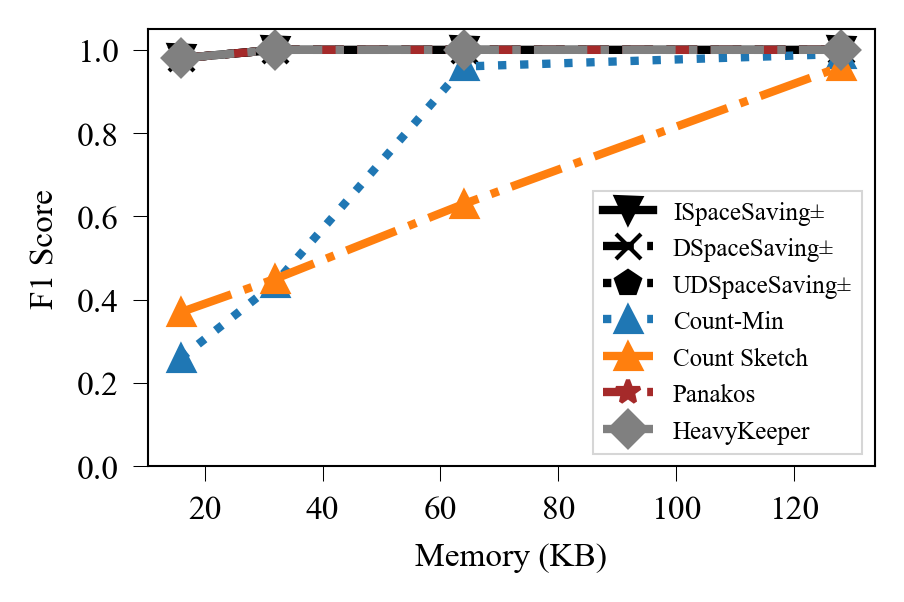

In [9]:
TopK('Social', 100, len(social), None, social)

insert_size:  1000000
[16, 32, 64, 128]
CM:  [0.89, 0.9500000000000001, 0.98, 1.0]
CS:  [0.9, 0.9500000000000001, 0.99, 0.98]
DSS:  [0.96, 0.99, 1.0, 1.0]
UDSS:  [0.96, 0.99, 1.0, 1.0]
ISS:  [0.97, 1.0, 1.0, 1.0]
Panakos:  [0.96, 0.99, 1.0, 1.0]
HeavyKeeper:  [0.97, 1.0, 1.0, 1.0]


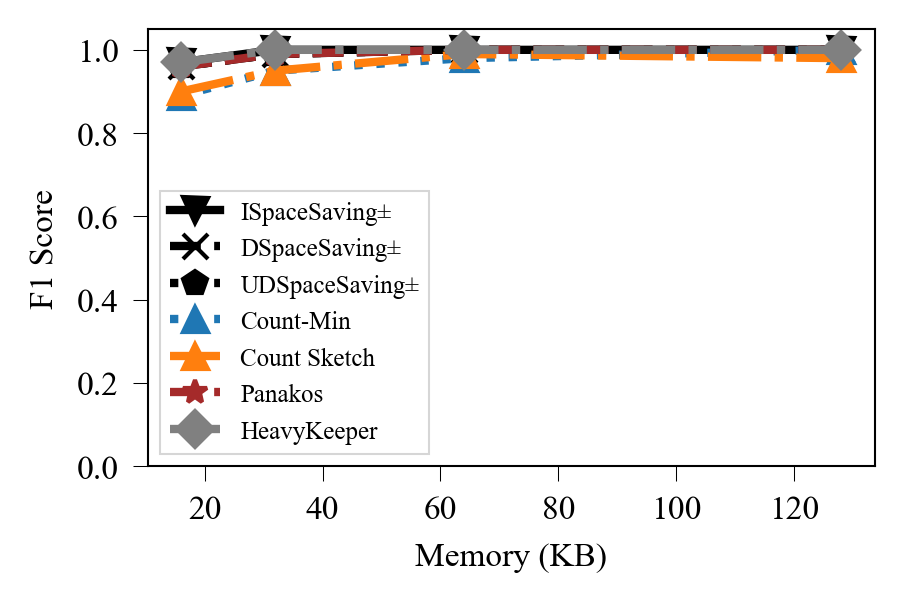

In [11]:
TopK('CAIDA', 100, 10**6, 0.5)

In [16]:
import time
def updatetime_and_querytime(streamType = "zipf", flag='updatetime'):
    random.seed(1)
    Turnstile_model_maker = ['^:','^-.']
    markers = ['kv-','kx--','kp:']
    
    CM_latency = []
    CS_latency = []
    ISS_latency = []
    DSS_latency = []
    UDSS_latency = []
    panakos_latency = []
    heavykeeper_latency = []
    stream_length = [2**12, 2**14, 2**15, 2**16,  2**18]
    
    universe = 2**21
    a = 1.0
    eps = 2**(-8)
    rate = 0.5
    r = rate

    for index, insert_size in enumerate(stream_length):
        insertoins = []
        deletions = []
        if streamType == "zipf":
            with open('./data/zipf1_inserts.json', 'r') as file:
                    insertions= json.load(file)
            insretions = insertions[:insert_size]
        deletions = random.sample(list(insertions), int(r*len(insertions)))
                
        CM = CountMinSketch(int(1/eps), 16) #cols, rows
        CS = CountSketch(16, int(1/eps))
        space_used = CM.space()
        print('number of counter needed: ', space_used)
        ISS = SpaceSaving(space_used//3) #item, insertcount, deletecount
        DSS = DoubleSpaceSaving(eps, space_used//2) #item and count, it will split once again b/t insert/delete
        UDSS = UnbiasedDSS(eps, space_used//2)
        panakos = Panakos(space_used)
        heavykeeper = HeavyKeeper((space_used-400)//1.5, 200)
            
        
        start_time = time.time()
        for i in insertions:
            CM.add(str(i), 1)
        for i in deletions:
             CM.add(str(i), -1)
        end_time = time.time()
        execution_time = end_time - start_time
        CM_latency.append( execution_time / (len(insertions) + len(deletions)) )
        
        start_time = time.time()
        for i in insertions:
            CS.add(str(i), 1)
        for i in deletions:
            CS.add(str(i), -1)
        end_time = time.time()
        execution_time = end_time - start_time
        CS_latency.append( execution_time / (len(insertions) + len(deletions)) )
        
        start_time = time.time()
        for i in insertions:
            ISS.update(str(i), 1)
        for i in deletions:
            ISS.update(str(i), -1)
        end_time = time.time()
        execution_time = end_time - start_time
        ISS_latency.append( execution_time / (len(insertions) + len(deletions)) )
        
        
        start_time = time.time()
        for i in insertions:
            DSS.update(str(i))
        for i in deletions:
            DSS.update(str(i), 1, False)
        end_time = time.time()
        execution_time = end_time - start_time
        DSS_latency.append( execution_time / (len(insertions) + len(deletions)) )
        
        start_time = time.time()
        for i in insertions:
            UDSS.update(str(i))
        for i in deletions:
            UDSS.update(str(i), 1, False)
        end_time = time.time()
        execution_time = end_time - start_time
        UDSS_latency.append( execution_time / (len(insertions) + len(deletions)) )
        
        start_time = time.time()
        for i in insertions:
            panakos.update(str(i))
        for i in deletions:
            panakos.update(str(i), -1)
        end_time = time.time()
        execution_time = end_time - start_time
        panakos_latency.append( execution_time / (len(insertions) + len(deletions)) )
        
        start_time = time.time()
        for i in insertions:
            heavykeeper.update(str(i))
        for i in deletions:
            heavykeeper.update(str(i), -1)
        end_time = time.time()
        execution_time = end_time - start_time
        heavykeeper_latency.append( execution_time / (len(insertions) + len(deletions)) )
        
        
        true_result = {}
        for i in insertions:
            true_result[str(i)] = true_result.get(str(i), 0) + 1
        for i in deletions:
            true_result[str(i)] = true_result.get(str(i), 0) - 1
            if true_result[str(i)] == 0:
                del true_result[str(i)]
    
        if flag != 'updatetime':
            # replace update time with query time
            # topk = 1000
            # trueTopK = heapq.nlargest(topk, true_result, key=true_result.get)
            trueTopK = true_result.keys()
            topk = len(trueTopK)

            start_time = time.time()
            for key in trueTopK:
                CM_estimate = CM.query(key)
            end_time = time.time()
            execution_time = end_time - start_time
            CM_latency[-1] = execution_time /topk

            start_time = time.time()
            for key in trueTopK:
                CS_estimate = CS.query(key)
            end_time = time.time()
            execution_time = end_time - start_time
            CS_latency[-1] = execution_time /topk


            start_time = time.time()
            for key in trueTopK:
                DSS_estimate = DSS.query(key)
            end_time = time.time()
            execution_time = end_time - start_time
            DSS_latency[-1] = execution_time /topk


            start_time = time.time()
            for key in trueTopK:
                UDSS_estimate = DSS.query(key)
            end_time = time.time()
            execution_time = end_time - start_time
            UDSS_latency[-1] = execution_time /topk

            start_time = time.time()
            for key in trueTopK:
                ISS_estimate = ISS.query(key)
            end_time = time.time()
            execution_time = end_time - start_time
            ISS_latency[-1] = execution_time /topk
            
            start_time = time.time()
            for key in trueTopK:
                panakos_estimate = panakos.query(key)
            end_time = time.time()
            execution_time = end_time - start_time
            panakos_latency[-1] = execution_time /topk
            
            start_time = time.time()
            for key in trueTopK:
                heavykeeper_estimate = heavykeeper.query(key)
            end_time = time.time()
            execution_time = end_time - start_time
            heavykeeper_latency[-1] = execution_time /topk
    
    for i in range(len(stream_length)):
        stream_length[i] = stream_length[i] * (1+r)
        
    plt.xlabel('Stream Length')
    plt.ylabel('Latency (second)')
    
    print("CM: ", CM_latency)
    print("CS: ", CS_latency)
    print("DSS: ", DSS_latency)
    print("UDSS: ", UDSS_latency)
    print("ISS: ", ISS_latency)
    print("Panakos: ", panakos_latency)
    print("HeavyKeeper: ", heavykeeper_latency)

#     plt.ylim(0.5*10**-6,10**-4)
#     if flag!='updatetime':
#         plt.ylim(10**-8,10**-3)
#     plt.xlim(2**12, 2**20)
                
    plt.yscale('log',basey=10)
    plt.xscale('log',basex=2)
    plt.plot(stream_length, ISS_latency, markers[0], label='ISpaceSaving\u00B1')
    plt.plot(stream_length, DSS_latency, markers[1], label='DSpaceSaving\u00B1')
    plt.plot(stream_length, UDSS_latency, markers[2], label='UDSpaceSaving\u00B1')
    plt.plot(stream_length, CM_latency, Turnstile_model_maker[0], label='Count-Min')
    plt.plot(stream_length, CS_latency, Turnstile_model_maker[1], label='Count Sketch')
    plt.plot(stream_length, panakos_latency, marker='*', linestyle='--', color='brown', label='Panakos')
    plt.plot(stream_length, heavykeeper_latency,  marker='D', linestyle='-.', color='grey', label='HeavyKeeper')

    plt.legend(loc='upper right')

number of counter needed:  4096
number of counter needed:  4096
number of counter needed:  4096
number of counter needed:  4096
number of counter needed:  4096
CM:  [2.8128883361816406e-05, 2.9508702119191488e-05, 2.7940901915232342e-05, 2.78759446144104e-05, 2.776098601023356e-05]
CS:  [6.479122877120972e-05, 6.38372073173523e-05, 6.586938540140788e-05, 6.591538079579672e-05, 6.76568546295166e-05]
DSS:  [1.3729971885681153e-05, 1.294184668858846e-05, 1.2918931325276692e-05, 1.2991839408874511e-05, 1.236501137415568e-05]
UDSS:  [1.278841733932495e-05, 1.2827288627624511e-05, 1.2762884616851807e-05, 1.296312936147054e-05, 1.3028977870941163e-05]
ISS:  [9.335384051005046e-06, 8.992900212605795e-06, 9.085642019907634e-06, 9.049435297648112e-06, 8.472190697987874e-06]
Panakos:  [1.751005458831787e-05, 1.7093624114990236e-05, 1.709318272272746e-05, 1.70992374420166e-05, 1.5889242013295492e-05]
HeavyKeeper:  [2.140861463546753e-05, 2.0775524775187176e-05, 2.111439339319865e-05, 2.04571922620

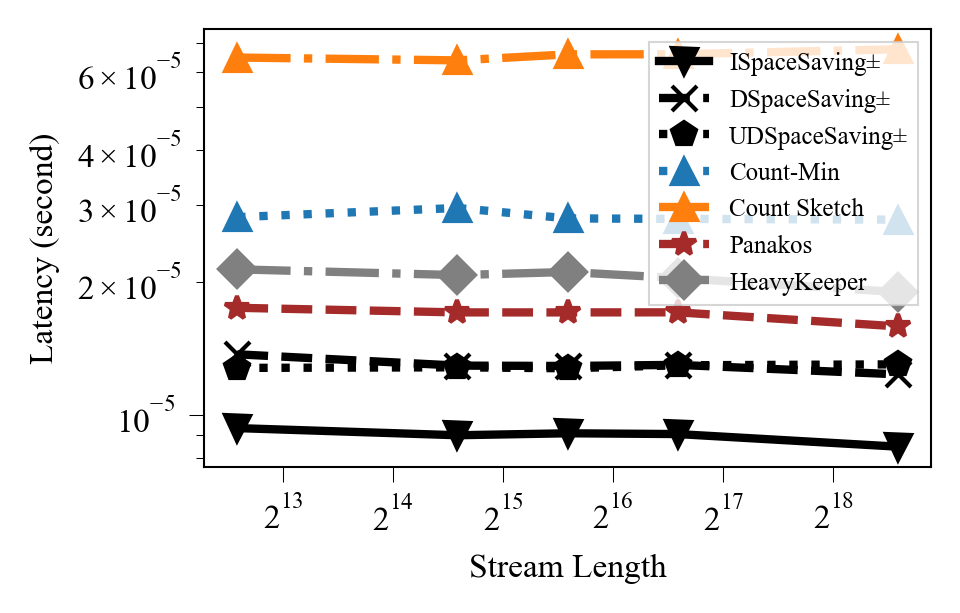

In [17]:
updatetime_and_querytime("zipf", "updatetime")

number of counter needed:  4096
number of counter needed:  4096
number of counter needed:  4096
number of counter needed:  4096
number of counter needed:  4096
CM:  [2.3141110866386337e-05, 2.2736446428067623e-05, 2.2704979205531663e-05, 2.298923419453729e-05, 2.2675984873830367e-05]
CS:  [9.529725212941678e-05, 9.70973021889335e-05, 9.781057916778155e-05, 9.505560084292498e-05, 9.707979811113191e-05]
DSS:  [6.611382747106594e-07, 6.927433829244737e-07, 6.621020708287764e-07, 6.861357062000101e-07, 6.604280080425361e-07]
UDSS:  [6.861294368330154e-07, 6.508453403921881e-07, 6.983479997352226e-07, 6.69905484481384e-07, 6.914149518545155e-07]
ISS:  [2.3275329672575083e-07, 2.1840541247831992e-07, 2.4724327079567706e-07, 2.3122480722429456e-07, 2.5056418842334377e-07]
Panakos:  [2.825067242794516e-06, 2.8145877546641517e-06, 2.908524023586827e-06, 2.8717072643199443e-06, 2.8167267770020635e-06]
HeavyKeeper:  [1.3219017801900919e-05, 1.378838175586464e-05, 1.3190006473672019e-05, 1.3251803

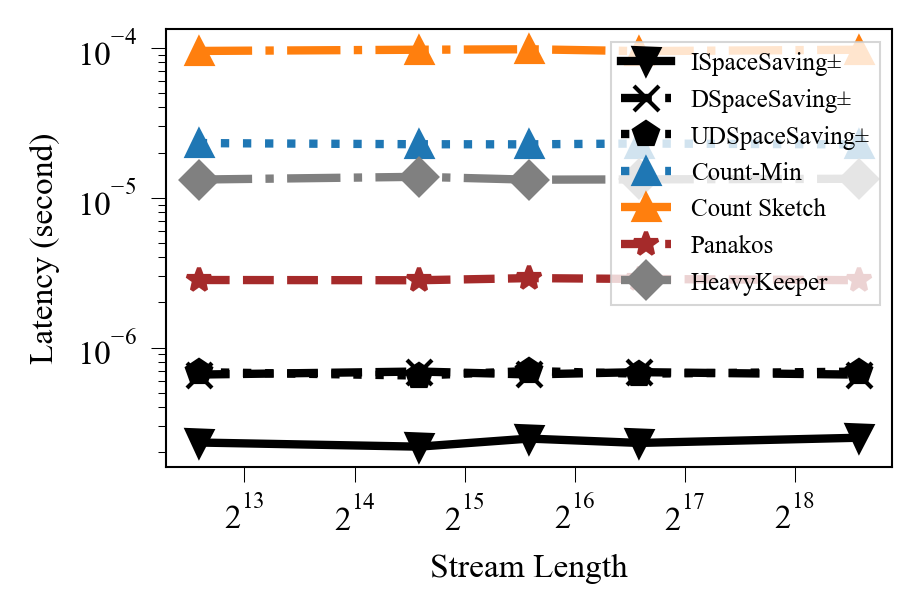

In [18]:
updatetime_and_querytime("zipf", "querytime")